### Project 2 - Shafya Nadour, Will Berritt, Jonathan Burns
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

In [43]:
##Loading the Data:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

node_edge_path = "https://raw.githubusercontent.com/jonburns2454/Data-620/master/DATA/soc-political-retweet.edges"
node_edge_data = pd.read_csv(node_edge_path, sep=',', header=None, names=['node', 'edge', 'weight'])

node_label_path = "https://raw.githubusercontent.com/jonburns2454/Data-620/master/DATA/soc-political-retweet.node_labels"
node_label_data = pd.read_csv(node_label_path, sep=',', header=None, names=['node', 'category'])


In [45]:
# Merge DataFrames
merged_data = node_edge_data.merge(node_label_data, left_on='node', right_on='node', how='left')


Replace categories 1 and 2 with more meaningfull names

In [46]:
# Changing the numeric classification column to left leaning and right leaning
merged_data['category'] = merged_data['category'].replace({2: 'Left', 1: 'Right'})

In [47]:
merged_data.head(3)

,node,edge,weight,category
0,12464,7349,1286901355,Right
1,6820,12569,1287988962,Left
2,4336,15967,1286535938,Right


Subset out the data and pull out only the middle chunk of the data (this set is way to large to feasibly graph any of it). So we subset the data and ran the island method on the highest weighted edges in the dataset below

In [37]:
import pandas as pd

# Assuming 'merged_data' is your DataFrame
length = len(merged_data)
start = length // 3
end = start * 2

# Selecting the middle third
middle_third = merged_data.iloc[start:end]

G = nx.from_pandas_edgelist(middle_third, 'node', 'edge', 'category')
# Add node labels as attributes
for _, row in middle_third.iterrows():
    G.nodes[row['node']]['category'] = row['category']

Distribution of the 'weight' column to understand what threshold we should set for the island method

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
print(middle_third['weight'].describe())

count    2.038500e+04
mean     1.286540e+09
std      1.237791e+06
min      1.284437e+09
25%      1.285437e+09
50%      1.286480e+09
75%      1.287650e+09
max      1.288651e+09
Name: weight, dtype: float64


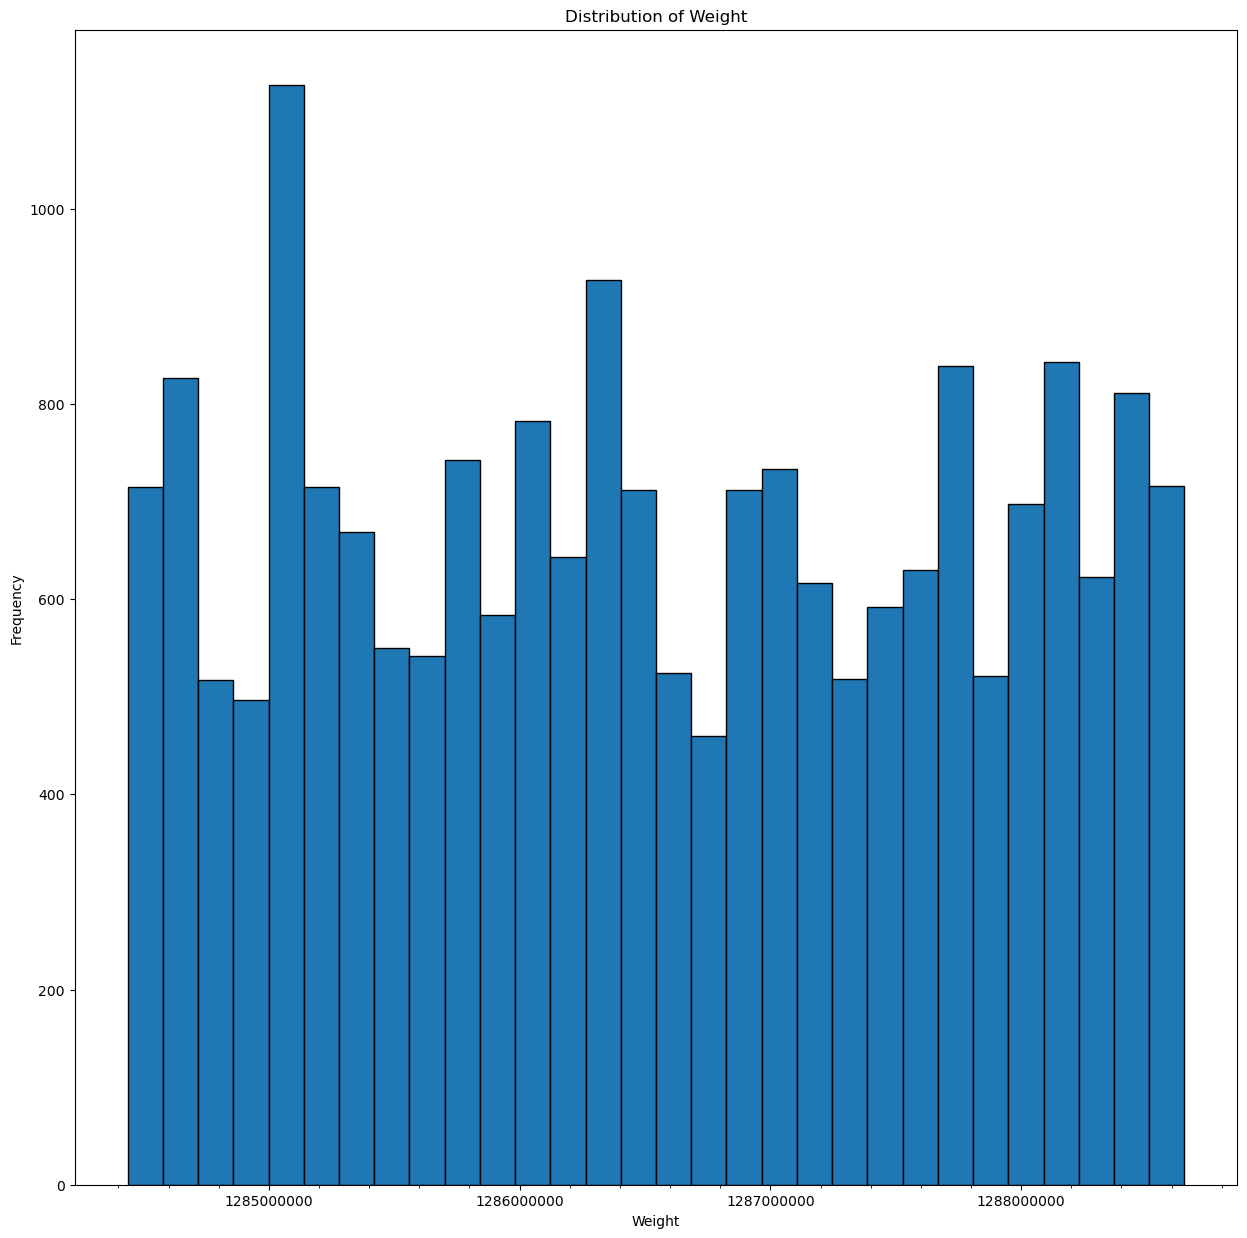

In [73]:
plt.hist(middle_third['weight'], bins=30, edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x') 

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically choose the number of ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()

So we can tell that the highest weighted edges in this dataset are somewhere above 1.288 (millions)

Set up a biparite graph looking at the full extent of our subset of twitter retweet data

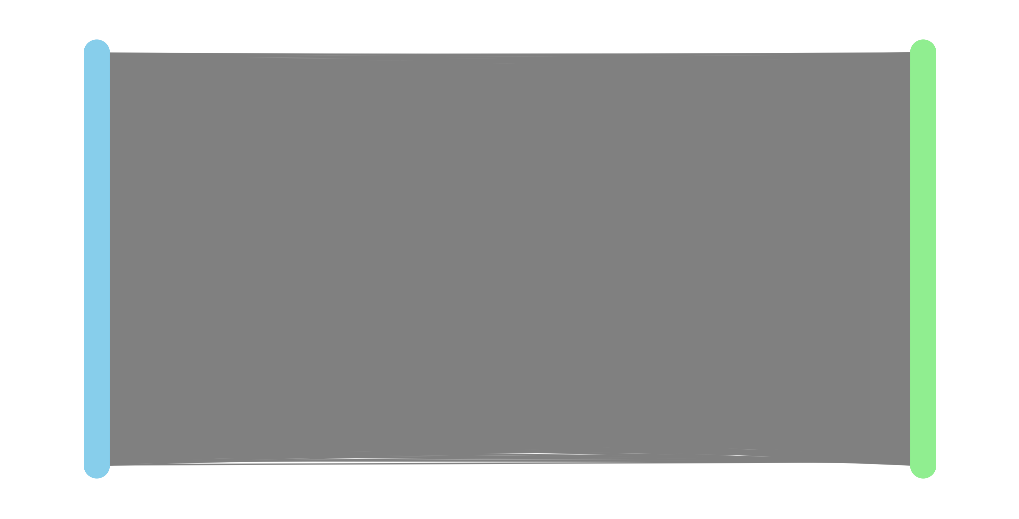

In [50]:
G = nx.Graph()


for index, row in middle_third.iterrows():
    G.add_node(row['node'], bipartite=0 if row['category'] == 'Left' else 1)
    G.add_node(row['edge'], bipartite=1 if row['category'] == 'Left' else 0)

   
    G.add_edge(row['node'], row['edge'], weight=row['weight'])

left_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
right_nodes = set(G) - left_nodes

pos = nx.bipartite_layout(G, left_nodes)

# Draw the graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()], edge_color='gray')

plt.show()

In [40]:
list(G.nodes(data=True))[:3]
list(G.nodes(data=True))[-2:]

[('Node1', {'bipartite': 0}), ('Node2', {'bipartite': 1})]

Wittle down the data to only pick the highest weighted edges and their corresponding nodes (using the histogram from above). Coloring this data by color also provides better insight into the relationship

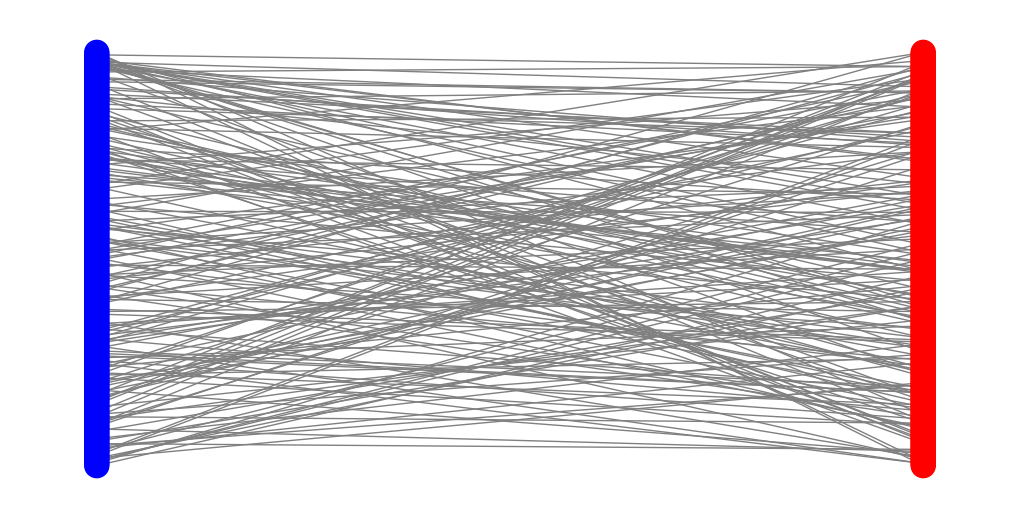

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


G = nx.Graph()


for index, row in middle_third.iterrows():
    G.add_node(row['node'], bipartite=0 if row['category'] == 'Left' else 1)
    G.add_node(row['edge'], bipartite=1 if row['category'] == 'Left' else 0)
    G.add_edge(row['node'], row['edge'], weight=row['weight'])


threshold = 1288600000 #threshold to look at only the highest weighted edges in the data
to_remove = [edge for edge in G.edges(data=True) if edge[2]['weight'] < threshold]
G.remove_edges_from(to_remove)

isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

left_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
right_nodes = set(G) - left_nodes

pos = nx.bipartite_layout(G, left_nodes)

# Draw the reduced graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, node_color=['blue' if n in left_nodes else 'red' for n in G.nodes()], edge_color='gray')
plt.show()

In [41]:
print("Sample node attributes:")
for node in list(G.nodes(data=True))[:5]:  # Print attributes of the first 5 nodes
    print(node)

Sample node attributes:
(6708, {'category': 2})
(9691, {'category': 1})
(14555, {'category': 1})
(11426, {'category': 2})
(675, {'category': 1})


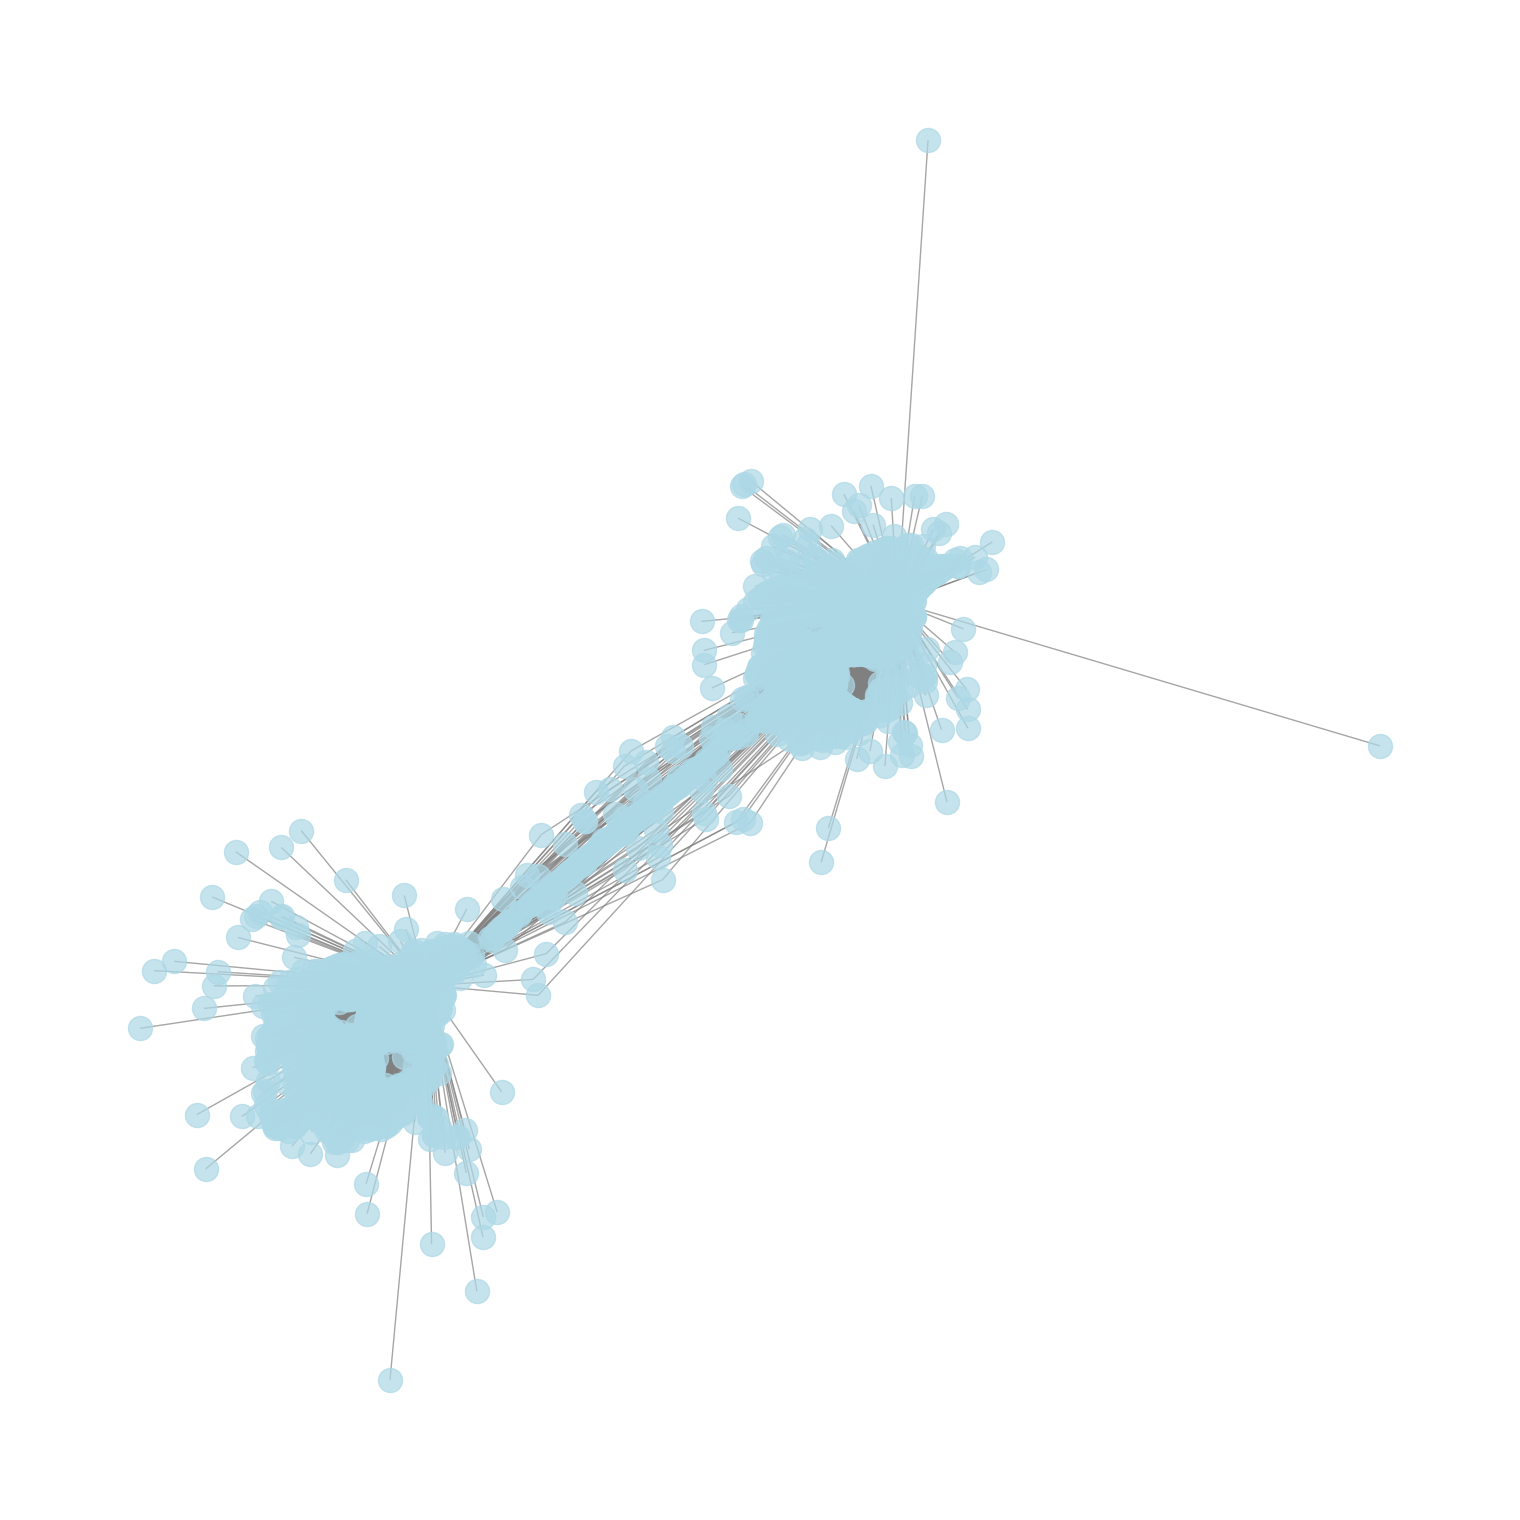

In [15]:
import networkx as nx


threshold = 1286100000
def island_method(G, threshold):
    H = nx.Graph()
    
    
    for f, t, edata in G.edges(data=True):
        if edata.get('weight', 0) > threshold:
            H.add_node(f)
            H.add_node(t)
            H.add_edge(f, t, weight=edata['weight'])
    
    return H
threshold = 1286100000
threshold_value = 0.5 
reduced_G = island_method(G, threshold_value)


nx.draw(reduced_G, with_labels=False, node_color='lightblue', edge_color='gray', alpha=0.7)

### Analysis
Our graphs for project 2 shows some clear grouping between the data with the right and left groups likely being clustering of left leaning and right leaning political retweets with twitter accounts.
This also shows, while there is a high level of interconnectedness, these groups are distinctly different and tend to stay within their own sphere of twitter.

Lastly, these graphs encapsulate the continued political polarization of twitter users. This data is not up to date either, if we had newer data for this project, we would expect there to be even tighter clustering, showing even more polarization of twitter. Further research would need to be done to identify exactly what each cluster represents, but it is clear that left and right leaning are the main features.